In [1]:
!pip install nltk==3.5
!pip install gensim
!pip install umap-learn
!pip install wikipedia
!pip install unidecode

In [2]:
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
import wikipedia
import string
from unidecode import unidecode
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import urllib.request
import bz2
import gensim
import warnings
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

# Definição do Corpus

## Base

In [61]:
wikipedia.set_lang("pt")
bh = wikipedia.page("Belo Horizonte")

In [62]:
corpus = bh.content

Selecionamos algumas frases do corpus de BH da wikipedia.

Conside a lista abaixo como nosso corpus de documentos. Cada elemento da lista, considere como um único documento.

In [63]:
documentos = \
["Belo Horizonte é um município brasileiro e a capital do estado de Minas Gerais",
"A populacao de Belo Horizonte é estimada em 2 501 576 habitantes, conforme estimativas do Instituto Brasileiro de Geografia e Estatística",
"Belo Horizonte já foi indicada pelo Population Crisis Commitee, da ONU, como a metrópole com melhor qualidade de vida na América Latina",
"Belo Horizonte é mundialmente conhecida e exerce significativa influência nacional e até internacional, seja do ponto de vista cultural, econômico ou político",
"Belo Horizonte é a capital do segundo estado mais populoso do Brasil, Minas Gerais"]

## Preprocessamento

<b> Atividade </b>

1) Escreva uma método que realiza o pré-processamento da lista de <b>documentos</b>.

O método deve, para cada documento:
- tokenizar cada palavra
- remover stopwords
- remover números
- remover pontuções
- remover acentos

In [6]:
def pre_processamento(corpus):
  print('tokenização')
  corpus_new = re.findall(r"\w+(?:'\w+)?|[^\w\s]", corpus)
  print('lowcase')
  corpus_new = [t.lower() for t in corpus_new]
  print('remover stopwords')
  corpus_pt_stopworld = stopwords.words('portuguese')
  corpus_new = [t for t in corpus_new if t not in corpus_pt_stopworld]
  print('remover números')
  corpus_new = [re.sub(r'\d', '', t) for t in corpus_new]
  print('remover pontuações')
  corpus_new = [t for t in corpus_new if t not in string.punctuation]
  print('remover acentos')
  corpus_new = [unidecode(t) for t in corpus_new]

  return corpus_new

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
corpus_processado = [pre_processamento(frase) for frase in documentos]
print(corpus_processado)

tokenização
lowcase
remover stopwords
remover números
remover pontuações
remover acentos
tokenização
lowcase
remover stopwords
remover números
remover pontuações
remover acentos
tokenização
lowcase
remover stopwords
remover números
remover pontuações
remover acentos
tokenização
lowcase
remover stopwords
remover números
remover pontuações
remover acentos
tokenização
lowcase
remover stopwords
remover números
remover pontuações
remover acentos
[['belo', 'horizonte', 'municipio', 'brasileiro', 'capital', 'estado', 'minas', 'gerais'], ['populacao', 'belo', 'horizonte', 'estimada', 'habitantes', 'conforme', 'estimativas', 'instituto', 'brasileiro', 'geografia', 'estatistica'], ['belo', 'horizonte', 'indicada', 'population', 'crisis', 'commitee', 'onu', 'metropole', 'melhor', 'qualidade', 'vida', 'america', 'latina'], ['belo', 'horizonte', 'mundialmente', 'conhecida', 'exerce', 'significativa', 'influencia', 'nacional', 'internacional', 'ponto', 'vista', 'cultural', 'economico', 'politico'], 

# Representação Textual

### Phrases - Gensim

Forma mais inteligente de calcular os bigrams. Ela calcula os bigramas levando em consideração a frequência do par das palavaras em todos os documentos.
Para isso ele treina um modelo e depois aplica no corpus.

```python
#treinamento bigrams
model_corpus_phrases = gensim.models.Phrases(corpus_processado, min_count=1)
#calulando os bigrams do corpus processado
bigram_corpus = model_corpus_phrases[corpus_processado]
```

<b> Atividade </b>

2) Faça um código que treine os bigrams, sendo que o <b>min_count = 1</b>. 
O <b>min_count</b> é a contagem mínima que aquele par de palavras deve aparecer junto para considerarmos com um token. Teste também com outros valores de mim_count. Depois imprima os bigramas de cada documento.
Use o corpus_processado.

In [9]:
model_corpus_phrases = gensim.models.Phrases(corpus_processado, min_count=1)
bigram_corpus = model_corpus_phrases[corpus_processado]

In [10]:
for i in range(0, len(bigram_corpus)):
  print("Doc", i)
  print(bigram_corpus[i])
  print(" ")

Doc 0
['belo_horizonte', 'municipio', 'brasileiro', 'capital', 'estado', 'minas_gerais']
 
Doc 1
['populacao', 'belo_horizonte', 'estimada', 'habitantes', 'conforme', 'estimativas', 'instituto', 'brasileiro', 'geografia', 'estatistica']
 
Doc 2
['belo_horizonte', 'indicada', 'population', 'crisis', 'commitee', 'onu', 'metropole', 'melhor', 'qualidade', 'vida', 'america', 'latina']
 
Doc 3
['belo_horizonte', 'mundialmente', 'conhecida', 'exerce', 'significativa', 'influencia', 'nacional', 'internacional', 'ponto', 'vista', 'cultural', 'economico', 'politico']
 
Doc 4
['belo_horizonte', 'capital', 'segundo', 'estado', 'populoso', 'brasil', 'minas_gerais']
 


## TD-IDF

Dica de leitura: https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.XklQxnVKj7c

Para representar o texto com TF-IDF utilizamos o TfidfVectorizer. A seguir apresentamos instruções sobre como utilizá-lo.

```python
#primeiro criamos o objeto
vect = TfidfVectorizer()
vect #aqui você pode observa todos os parâmetros que o objeto possui
## Existem alguns parâmetros, opcionais, que podemos informar para uma possível melhora do nosso modelo. Por exemplo:
### inclui 1-grams e 2-grams
vect.set_params(ngram_range=(1, 2))
### ignora termos que a aparecem em mais de 50% dos documentoss
vect.set_params(max_df=0.5)
### só considero termos que aparecem em ao menos 2 documentos
vect.set_params(min_df=2)

#depois aplicamos fit_transform para transformar o texto em números
docs_tdidf = vect.fit_transform(docs)

#o docs_tdidf é uma matriz com os números que representam cada um dos textos. 
## Conseguimos verificar a dimensão desta matriz:
print(docs_tdidf.shape)

#Para visualizar as features capturadas pelo TF-IDF utilize:
print(vect.get_feature_names())
#Para visualizar os vetores correspondentes a cada palavara utilize:
df = pd.DataFrame(docs_tdidf.T.todense(), index=vect.get_feature_names(), columns=["doc"+str(i+1) for i in range(0,len(docs))])
df
```

<b> Atividade: </b>

3) Faça o TDIFTVectorizer nos documentos da variável <b>documentos</b> sem alterar nenhum parâmetro. 

In [11]:
vect = TfidfVectorizer()
vect
docs_tdidf = vect.fit_transform(documentos)

<b> Atividade </b>

4) Imprima o shape do resultado da atividade 4

In [12]:
#Não entendi a pergunta direito, coloquei das duas formas
print(docs_tdidf[4].shape)

(1, 59)


In [13]:
print(docs_tdidf.shape)

(5, 59)


<b> Atividade </b>

5) Imprima as features capturadas em 4.

In [117]:
print(vect.get_feature_names())

['501', '576', 'américa', 'até', 'belo', 'brasil', 'brasileiro', 'capital', 'com', 'commitee', 'como', 'conforme', 'conhecida', 'crisis', 'cultural', 'da', 'de', 'do', 'econômico', 'em', 'estado', 'estatística', 'estimada', 'estimativas', 'exerce', 'foi', 'geografia', 'gerais', 'habitantes', 'horizonte', 'indicada', 'influência', 'instituto', 'internacional', 'já', 'latina', 'mais', 'melhor', 'metrópole', 'minas', 'mundialmente', 'município', 'na', 'nacional', 'onu', 'ou', 'pelo', 'político', 'ponto', 'populacao', 'population', 'populoso', 'qualidade', 'segundo', 'seja', 'significativa', 'um', 'vida', 'vista']


6) Imprima os vetores correspondentes a cada palavra de cada documento.

In [15]:
df = pd.DataFrame(docs_tdidf.T.todense(), index=vect.get_feature_names(), columns=["doc"+str(i+1) for i in range(0,len(documentos))])
df

,doc1,doc2,doc3,doc4,doc5
501,0.000000,0.270250,0.000000,0.000000,0.000000
576,0.000000,0.270250,0.000000,0.000000,0.000000
américa,0.000000,0.000000,0.230808,0.000000,0.000000
até,0.000000,0.000000,0.000000,0.249308,0.000000
belo,0.189192,0.128776,0.109981,0.118797,0.165125
brasil,0.000000,0.000000,0.000000,0.000000,0.346534
brasileiro,0.320330,0.218036,0.000000,0.000000,0.000000
capital,0.320330,0.000000,0.000000,0.000000,0.279581
com,0.000000,0.000000,0.230808,0.000000,0.000000
commitee,0.000000,0.000000,0.230808,0.000000,0.000000


## Bag of Words

Para representar o bag of words utilizamos o CountVectorizer

```python
#primeiro criamos o objeto
vect_bag = CountVectorizer(binary=True) #se binary = False -> ocorre a contagem da frequência em que a palavra aparece
vect_bag #imprime os parâmetros

```

<b> Atividade </b>

7) Faça o CountVectorizer nos documentos da variável <b>documentos</b> considerando binary = True

In [16]:
vect_bag = CountVectorizer(binary=True)
vetorb =vect_bag.fit_transform(documentos)

<b> Atividade </b>

8) Imprima o índice correspondente a cada token da lista retornada por vect_bag.get_feature_names()

In [17]:
vect_bag.get_feature_names()
df = pd.DataFrame(vetorb.T.todense(), index=vect.get_feature_names(), columns=["doc"+str(i+1) for i in range(0,len(documentos))]).T
df

,501,576,américa,até,belo,brasil,brasileiro,capital,com,commitee,como,conforme,conhecida,crisis,cultural,da,de,do,econômico,em,estado,estatística,estimada,estimativas,exerce,foi,geografia,gerais,habitantes,horizonte,indicada,influência,instituto,internacional,já,latina,mais,melhor,metrópole,minas,mundialmente,município,na,nacional,onu,ou,pelo,político,ponto,populacao,population,populoso,qualidade,segundo,seja,significativa,um,vida,vista
doc1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
doc2,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,1,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
doc3,0,0,1,0,1,0,0,0,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0
doc4,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,1
doc5,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


## Embedding

### Utilizando um embedding treinado

<b> Atividade </b>

9) Faça download do seguinte arquivo, realize a leitura deste arquivo e carregue o modelo: 
https://drive.google.com/file/d/1f5sNZcV8LDam4zxbHnkm472r3r8D_UpX/view?usp=sharing

Depois suba no seu drive e carregue,

obs.: como o embedding é pesado, demora um pouco para carregar, cerca de 4 minutos.

In [18]:
#opção 1 -> montar o drive no colab e acessar o arquivo de embedding do drive
from google.colab import drive
drive.mount('/content/drive')

#opção 2 -> fazer download e fazer upload por aqui
#from google.colab import files
#uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
%%time
# carregar
##na variável path coloque o caminho do embedding baixado:
path = "/content/drive/MyDrive/Colab Notebooks/Bases/ptwiki_20180420_100d.txt"
word_vectors = gensim.models.KeyedVectors.load_word2vec_format(path, binary=False)

CPU times: user 1min 8s, sys: 1.59 s, total: 1min 10s
Wall time: 1min 16s


<b> Atividade </b>

10) Imprima os vetores das palavras "nlp" e "computacao"

```python
#exemplo de retorno do vetor
word_vectors[__]
```

In [20]:
word_vectors['nlp']

array([ 0.8528,  0.1094, -0.0296, -0.0458, -0.2029, -0.1839, -0.2012,
       -0.111 , -0.0315,  0.1895, -0.2194, -0.3496, -0.1319, -0.1594,
        0.1549, -0.493 ,  0.1897, -0.296 ,  0.0026,  0.2015,  0.0215,
        0.2946, -0.2024,  0.3931,  0.143 ,  0.0667, -0.4868,  0.048 ,
       -0.1028,  0.2372,  0.2042, -0.8025, -0.1221,  0.475 , -0.2997,
        0.219 ,  0.1232, -0.2118,  0.5402, -0.0768,  0.2253,  0.1285,
       -0.6157,  0.1777,  0.0306, -0.1094, -0.1649, -0.386 , -0.2692,
        0.3149,  0.0391, -0.0821, -0.2238,  0.033 ,  0.5032,  0.0836,
        0.1834, -0.2009, -0.0722, -0.1744,  0.3946, -0.0792, -0.0863,
        0.3813,  0.5876, -0.4447, -0.5435,  0.1528, -0.1012, -0.0967,
       -0.2621,  0.4737,  0.3235, -1.1013, -0.0789,  0.1945, -0.1304,
       -0.0379,  0.899 ,  0.0398,  0.2908, -0.4276, -0.0641, -0.3841,
        0.354 ,  0.4139,  0.1076, -0.3439, -0.1474, -0.1215,  0.4359,
       -0.1563,  0.2577,  0.4333,  0.2003, -0.4064, -0.818 ,  0.0812,
       -0.2554, -0.4

In [21]:
word_vectors['computacao']

array([ 0.5076, -0.2598,  0.0993,  0.1021, -0.2076, -0.2745,  0.0104,
        0.0107,  0.0151,  0.2485, -0.2933,  0.1184, -0.4087, -0.0381,
        0.0528, -0.2312,  0.1387,  0.1144,  0.0291,  0.164 , -0.0941,
        0.1045, -0.1874,  0.0116,  0.1133, -0.11  , -0.0607,  0.047 ,
       -0.0259,  0.4073,  0.1337, -0.3197,  0.0559,  0.2985, -0.0571,
       -0.2967,  0.0675,  0.1016,  0.4049, -0.347 ,  0.1782, -0.2004,
       -0.1565, -0.0758,  0.3695,  0.0918, -0.0197, -0.4832, -0.5214,
        0.124 ,  0.3514,  0.1103,  0.0646, -0.0722,  0.2532, -0.0997,
       -0.0581, -0.0238, -0.164 , -0.0828,  0.5997, -0.1605,  0.0169,
        0.3451,  0.3026, -0.0841, -0.1699,  0.2674,  0.0184, -0.1471,
       -0.218 , -0.0565, -0.1998, -0.3754, -0.1754,  0.1689, -0.2062,
        0.2613,  0.1208, -0.217 ,  0.1932, -0.3372, -0.119 , -0.1323,
       -0.4022,  0.0883,  0.1728, -0.2999, -0.0619,  0.3041,  0.1596,
       -0.2037,  0.1473, -0.0561,  0.1435, -0.0683, -0.2464, -0.0562,
        0.0109,  0.0

<b> Similaridade de Vetores </b> 

No gensim é possível realizar a similaridade utilizando o seguinte método:

```python
word_vectors.most_similar(___)
```

<b> Atividade </b>

11) Verifique a similaridade das seguintes palavras: elizabete, raiva, segunda, dois, computação.

In [22]:
word_vectors.most_similar("elizabete")

[('joana', 0.7828384041786194),
 ('elídia', 0.7808018922805786),
 ('arcângela', 0.7692556381225586),
 ('maria', 0.7659809589385986),
 ('felisbela', 0.7649518847465515),
 ('andreza', 0.7636873722076416),
 ('thomazia', 0.7636217474937439),
 ('francisca', 0.7602137327194214),
 ('eleonora', 0.7596681118011475),
 ('deodata', 0.7594977617263794)]

In [23]:
word_vectors.most_similar("raiva")

[('medo', 0.8303433656692505),
 ('frustração', 0.8079831600189209),
 ('desespero', 0.8039345741271973),
 ('tristeza', 0.800615668296814),
 ('remorso', 0.7922823429107666),
 ('desgosto', 0.7901228666305542),
 ('inveja', 0.781806468963623),
 ('ciúmes', 0.7798185348510742),
 ('ódio', 0.776374101638794),
 ('repugnância', 0.7657582759857178)]

In [24]:
word_vectors.most_similar("segunda")

[('primeira', 0.8965903520584106),
 ('quarta', 0.8717238903045654),
 ('terceira', 0.8408156037330627),
 ('última', 0.8141331672668457),
 ('sétima', 0.807178258895874),
 ('sexta', 0.7998778820037842),
 ('décima', 0.7983245849609375),
 ('penúltima', 0.7719092965126038),
 ('nona', 0.7675511240959167),
 ('oitava', 0.7670223712921143)]

In [25]:
word_vectors.most_similar("dois")

[('três', 0.8804982304573059),
 ('quatro', 0.8787742257118225),
 ('seis', 0.844917893409729),
 ('cinco', 0.8440984487533569),
 ('oito', 0.8346582651138306),
 ('ambos', 0.82096266746521),
 ('nove', 0.8060351014137268),
 ('vários', 0.8052262663841248),
 ('os', 0.8016588091850281),
 ('sete', 0.7854640483856201)]

In [26]:
word_vectors.most_similar("computação")

[('computacional', 0.8587305545806885),
 ('informática', 0.8066875338554382),
 ('microeletrônica', 0.7903156280517578),
 ('bioinspirada', 0.7866970300674438),
 ('computacionais', 0.7839764356613159),
 ('biomatemática', 0.7749572992324829),
 ('ubicomp', 0.7651089429855347),
 ('lamce', 0.7647029757499695),
 ('imecc', 0.7626293897628784),
 ('bioinformática', 0.7598603963851929)]

<b> Operação Vetorial</b>

Na aula teórica, estudamos sobre as operação entre os vetores. 
Agora vamos ver na prática:

```python
#exemplo:
word_vectors.wv.most_similar(positive=['mulher', 'rei'], negative=['homem'], topn=10)
```

<b>Atividade</b>

12) Execute o exemplo acima em uma célula e repita para os seguintes cenários:

- menino, menina, homem
- caminhada, andar, correr
- filho, filha, irmã
- pai, mãe, avô

<b> Reflita </b> as palavras similares fazem sentido?

In [27]:
word_vectors.wv.most_similar(positive=['menino', 'menina'], negative=['homem'], topn=10)

[('garotinha', 0.746025800704956),
 ('criança', 0.7124738693237305),
 ('izildinha', 0.6914386749267578),
 ('garota', 0.6765151619911194),
 ('órfã', 0.6759505271911621),
 ('filhinha', 0.6749870777130127),
 ('avó', 0.6711723804473877),
 ('babá', 0.6623851656913757),
 ('irmãzinha', 0.6621854305267334),
 ('moça', 0.6594897508621216)]

In [28]:
word_vectors.wv.most_similar(positive=['caminhada', 'andar'], negative=['correr'], topn=10)

[('caminhadas', 0.618974506855011),
 ('pavimento', 0.606018602848053),
 ('passeio', 0.6024052500724792),
 ('piquenique', 0.598796546459198),
 ('sala', 0.5944793224334717),
 ('terraço', 0.5920617580413818),
 ('rampa', 0.5885153412818909),
 ('passarela', 0.5874667167663574),
 ('climatizada', 0.5863767862319946),
 ('calçadão', 0.5852184295654297)]

In [29]:
word_vectors.wv.most_similar(positive=['filho', 'filha'], negative=['irmã'], topn=10)

[('bisneto', 0.851236879825592),
 ('neto', 0.8316095471382141),
 ('primogênito', 0.8290099501609802),
 ('bisavô', 0.822635293006897),
 ('sobrinho', 0.8176089525222778),
 ('avô', 0.816977858543396),
 ('sogro', 0.8009151220321655),
 ('pai', 0.799014687538147),
 ('primogénito', 0.785844624042511),
 ('genro', 0.7755304574966431)]

In [30]:
word_vectors.wv.most_similar(positive=['pai', 'mãe'], negative=['avô'], topn=10)

[('avó', 0.8150790929794312),
 ('adotiva', 0.8064451813697815),
 ('irmã', 0.7990934252738953),
 ('esposa', 0.7982308268547058),
 ('madrasta', 0.7841061353683472),
 ('tia', 0.7805376052856445),
 ('falecida', 0.7775087356567383),
 ('eutímia', 0.7673025727272034),
 ('superprotegida', 0.7659645676612854),
 ('consternada', 0.7656985521316528)]

### Treinando seu embedding

Aqui vamos utilizar o corpus machado. São textos/contos escritos por Machado de Assis.
Esse corpus é diponibilizado pelo NLTK.

In [31]:
from nltk.corpus import machado

In [32]:
import nltk
from nltk.corpus import machado
nltk.download('machado')

[nltk_data] Downloading package machado to /root/nltk_data...
[nltk_data]   Package machado is already up-to-date!


True

In [33]:
raw_casmurro = machado.raw('contos/macn001.txt')

O método ''machado_sents()'' retorna todo o texto quebrado pelas setenças e já tokenizado.

As sentenças são separadas pelo "\n". Dentro de cada sentença, divide os tokens separadas pelo espaço.

In [34]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
machado_sents = machado.sents()
print(machado_sents)

[['Conto', ',', 'Contos', 'Fluminenses', ',', '1870'], ['Contos', 'Fluminenses'], ...]


Vamos relizar um pré-processamento mínimo nos dados. Lembrando que: o pré-processamento é impotatíssimo no resultado final.

<b> Atividade </b>

13) Aplique as técnicas abaixo no documento <b> machado_sents</b>: 

- lower
- remoção pontuações

In [36]:
texto_machado_limpo = [[palavra.lower() for palavra in sentence if palavra not in string.punctuation] for sentence in machado_sents]

<b> Treinando o embedding </b> 

Para treinar os embeddings existem alguns parâmetros, vide exemplo abaixo:

```python
#Alguns parâmetros:
## size -> dimensão vetor
## min_count -> ignora todas palavras cuja frequência mínima é menor que este
## workers -> quantas threads serão utilizadas para treinar o modelo
## seed -> seed para geração do numero aleatório. 
## sg -> 1 para skip-gram; caso contrário CBOW.
## window -> contexto, Distância máxima entre a palavra atual e a prevista em uma frase. O default é 5.
model = word2vec.Word2Vec(text_preproc, min_count=10, workers=4, seed=123, sg=1, size=300, window=5)
```

<b> Atividade </b>

14) Gere os embeddings com o texto processado do documento de Machado de Assis.


In [37]:
model = word2vec.Word2Vec(texto_machado_limpo, min_count=10, workers=4, seed=123, sg=1, size=300, window=5)


<b> Atividade </b>

15) Faça os itens abaixo:

- Verifique o vetor de embeddings da variável "dom"
- Verifique a similaridade entre "mulher" e "homem"
- Verifique a similaridade entre "dom" e "casmurro"

In [38]:
model["dom"]

array([ 2.46623382e-02, -1.79799497e-01, -4.55295853e-02,  9.98698249e-02,
       -1.28638625e-01, -8.56027007e-03, -8.14282224e-02,  7.28060082e-02,
       -2.76268899e-01, -7.74742663e-02,  3.27441394e-02, -1.32716419e-02,
        4.53083962e-03,  1.24625318e-01,  3.54764760e-02,  4.06800546e-02,
        8.25202763e-02,  6.16482720e-02,  6.69777468e-02, -8.48801658e-02,
        2.33934596e-02, -2.50353366e-01, -6.43717945e-02,  1.45843029e-01,
       -9.96185094e-03, -1.92890335e-02,  9.74601284e-02,  1.48234606e-01,
        2.33132951e-02, -5.12143336e-02, -2.12300077e-01, -1.20087653e-01,
        3.72971259e-02,  2.29516253e-02,  2.91521072e-01, -5.08417562e-02,
        1.40132941e-02,  6.60813376e-02, -7.27419630e-02,  1.09807737e-01,
        1.34004161e-01, -1.19499639e-01, -3.43735814e-01, -3.98035310e-02,
        5.99022992e-02,  1.43913431e-02,  1.50906339e-01, -1.41865656e-01,
        1.98086854e-02, -8.62809643e-02,  1.48854032e-01,  3.09867151e-02,
       -1.44754425e-01,  

In [39]:
model.wv.most_similar(positive=['mulher'], negative=['homem'], topn=10)

[('irmã', 0.4433215260505676),
 ('amiga', 0.42843353748321533),
 ('madrinha', 0.40657585859298706),
 ('noiva', 0.39887291193008423),
 ('mãe', 0.3765908479690552),
 ('júlia', 0.3707626461982727),
 ('teresa', 0.36557620763778687),
 ('julieta', 0.3618319034576416),
 ('tia', 0.35566312074661255),
 ('prima', 0.3553912937641144)]

In [40]:
word_vectors.wv.most_similar(positive=['mulher', 'homem'], topn=10)

[('rapaz', 0.772354006767273),
 ('travestia', 0.7695128917694092),
 ('moça', 0.751427412033081),
 ('cleptomaníaca', 0.7499310970306396),
 ('culpasse', 0.7490247488021851),
 ('menina', 0.7396829128265381),
 ('criança', 0.7395275831222534),
 ('pirgopolinices', 0.7394336462020874),
 ('spindella', 0.7391446828842163),
 ('inocente', 0.738737940788269)]

In [41]:
model.wv.most_similar(positive=['dom'], negative=['casmurro'], topn=10)

[('modelo', 0.271146297454834),
 ('eminente', 0.23938317596912384),
 ('joaquim', 0.2389635145664215),
 ('culto', 0.23701831698417664),
 ('poema', 0.23521819710731506),
 ('homero', 0.23239949345588684),
 ('elemento', 0.22509215772151947),
 ('hugo', 0.21425002813339233),
 ('gênio', 0.21298305690288544),
 ('caráter', 0.21115605533123016)]

In [42]:
word_vectors.wv.most_similar(positive=['dom', 'casmurro'], topn=10)

[('quixote', 0.7614538669586182),
 ('perlimplim', 0.7565604448318481),
 ('koaik', 0.7429561614990234),
 ('assis', 0.741490364074707),
 ('bergonzini', 0.7389904260635376),
 ('dalvit', 0.7323393225669861),
 ('zattera', 0.732326090335846),
 ('demettino', 0.7277851104736328),
 ('misiara', 0.7227809429168701),
 ('belvino', 0.7218409776687622)]

<b> Salvando o modelo</b>

In [74]:
model.wv.save_word2vec_format('model_TESTE.bin', binary=True)

<b> Atividade </b>

Dada as seguintes palavras:

foi, relógio, amor, raiva, brasil.

16) Escreva um método que retorne uma lista com as 5 palavras similares de cada uma das listadas anteriormente.
Imprima a lista das palavras similares, incluindo a palavra origem.

In [122]:
#model = gensim.models.KeyedVectors.load("model_TESTE.bin")
foi = model.most_similar(positive=[model.wv['foi']], topn=6)
print(foi)

[('foi', 1.0), ('fui', 0.5762040615081787), ('passou', 0.5593694448471069), ('substituiu', 0.5525878667831421), ('serviu', 0.5434169769287109), ('aventurou', 0.5229870676994324)]


In [124]:
relogio = model.most_similar(positive=[model.wv['relógio']], topn=6)
print(relogio)

[('relógio', 0.9999999403953552), ('embrulho', 0.7144136428833008), ('cigarro', 0.7104988098144531), ('rolo', 0.7049790620803833), ('paletó', 0.7043344974517822), ('revólver', 0.6978468894958496)]


In [123]:
amor = model.most_similar(positive=[model.wv['amor']], topn=6)
print(amor)

[('amor', 0.9999998807907104), ('ciúme', 0.7007174491882324), ('afeto', 0.6624516248703003), ('arrependimento', 0.6551109552383423), ('orgulho', 0.651790976524353), ('casto', 0.6442558169364929)]


In [125]:
raiva = model.most_similar(positive=[model.wv['raiva']], topn=6)
print(raiva)

[('raiva', 1.0), ('assustada', 0.8181374073028564), ('enxugar', 0.8014365434646606), ('mordia', 0.7989342212677002), ('morder', 0.7957184314727783), ('brandamente', 0.7923932671546936)]


In [126]:
brasil = model.most_similar(positive=[model.wv['brasil']], topn=6)
print(brasil)

[('brasil', 1.0), ('méxico', 0.7969744205474854), ('parlamento', 0.7857391238212585), ('maranhão', 0.7796949148178101), ('município', 0.7780003547668457), ('paraguai', 0.766044020652771)]


### Visualização

Para a visualização dos embeddings iremos  construir um array com todas as palavras retornadas anteriormente.

<b> Atividade </b>

17) Primeiro, gere uma única lista com todas as palavras retornadas anteriomente. O array deve ter tamanho 30.

In [128]:
all = foi + brasil + amor + relogio + raiva
all_words = re.findall(r"\w+(?:'\w+)?|[^\w\s]", str(all))
all_words = [t.lower() for t in all_words]
all_words = [re.sub(r'\d', '', t) for t in all_words]
all_words = [t for t in all_words if t not in string.punctuation]
len(all_words)

30

18) O código abaixo gera um array com todos os embeddings das palavras anteriores. Este array terá dimensão (30,300)

In [129]:
array_embeddings = np.empty((0,300), dtype='f')
for w in all_words:
  array_embeddings = np.append(array_embeddings, np.array([model[w]]), axis=0)
print(array_embeddings.shape)

(30, 300)


<b>Dica: </b> Use a função abaixo para plotar o array 2D que será gerado com o método PCA, TSNE e UMAP

In [130]:
def plot_embedding_2d(array_2d, all_words, words_seed):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    for (x, y), w in zip(array_2d, all_words):
        ax.scatter(x, y, c='red' if w in words_seed else 'blue')
        ax.annotate(w,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

#### PCA

<b> É uma ténica que existe a mais de século. É rápido, determinístico e linear. Essa linearidade limita sua utilidade em domínios complexos, como linguagem natural ou imagens, onde a estrutura não linear. </b>

Mais informações: https://medium.com/towards-artificial-intelligence/machine-learning-dimensionality-reduction-via-principal-component-analysis-1bdc77462831


<b> Atividade </b>

19) Gere a visualização dos embeddings anteriores utilizando o PCA para reduzir a dimensionalidade.

Exemplo do PCA:

```python
#uso de PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(array_embeddings)
```

In [133]:
palavras = ['foi', 'amor', 'relógio', 'brasil', 'raiva']

In [131]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(array_embeddings)

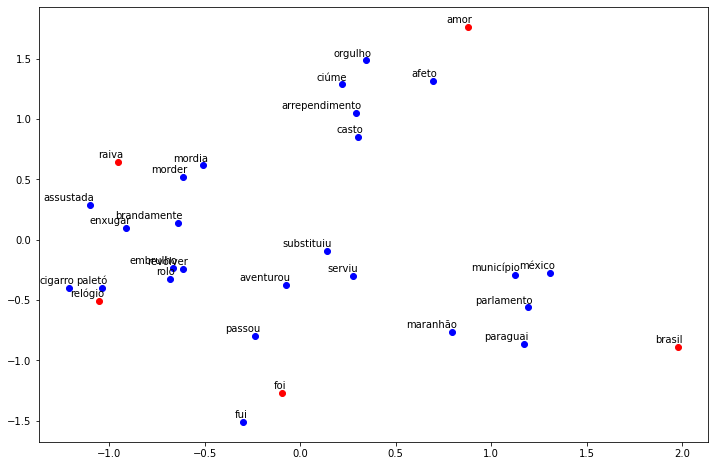

In [134]:
plot_embedding_2d(pca_result, all_words, palavras)

#### TSNE
<b> Uma técnica mais recente que captura estrutura não linear é o t-SNE, que significa distribuição estocástica de embedding viziznhos em t ( t-distributed Stochastic Neighbor Embedding). 
É uma ótima técnica para capturar a estrutura não linear em dados de alta dimensão(pelo menos em nível local). Isto é, dois pontos que são próximos no espaço de alta dimensão a probabilidade de estarem próximos em uma dimensão baixa é alta. </b>

Mais informações: https://medium.com/@garora039/dimensionality-reduction-using-t-sne-effectively-cabb2cd519b

<b> Atividade </b>

20) Gere a visualização dos embeddings anteriores utilizando o TSNE para reduzir a dimensionalidade.

Exemplo do TSNE:

```python
#uso de TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=4)
tsne_result =  tsne.fit_transform(array_embeddings)
```

In [112]:
tsne = TSNE(n_components=2, random_state=0, perplexity=4)
tsne_result =  tsne.fit_transform(array_embeddings)

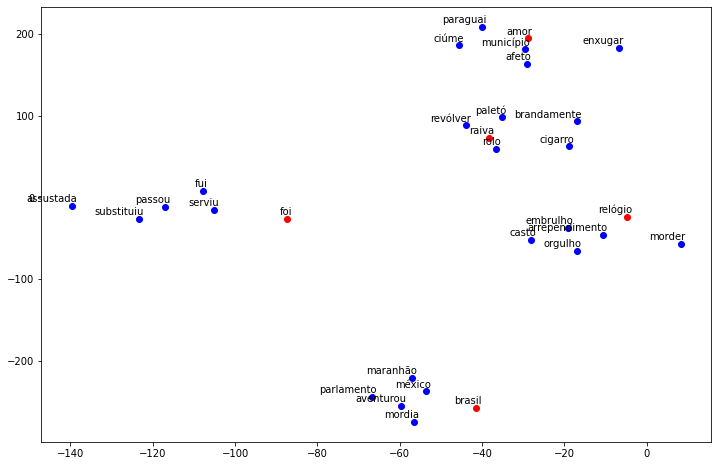

In [135]:
plot_embedding_2d(tsne_result, all_words, palavras)

#### UMAP

<b> Técnica super nova!! Foi lançada em 2018! Observe que o resultado do UMAP com o TSNE é semelhante. Mas existem várias vantagens do UMAP, por exemplo: é mais rápido que o t-SNE; ele captura melhor a estrutura global </b>

Mais informações: https://medium.com/@dan.allison/dimensionality-reduction-with-umap-b081837354dd

<b> Atividade </b>

21) Gere a visualização dos embeddings anteriores utilizando o UMAP para reduzir a dimensionalidade.

Exemplo do UMAP:

```python
#uso de TSNE
umap = umap.UMAP()
umap_result =  umap.fit_transform(array_embeddings)
```

In [114]:
umap = umap.UMAP()
umap_result =  umap.fit_transform(array_embeddings)

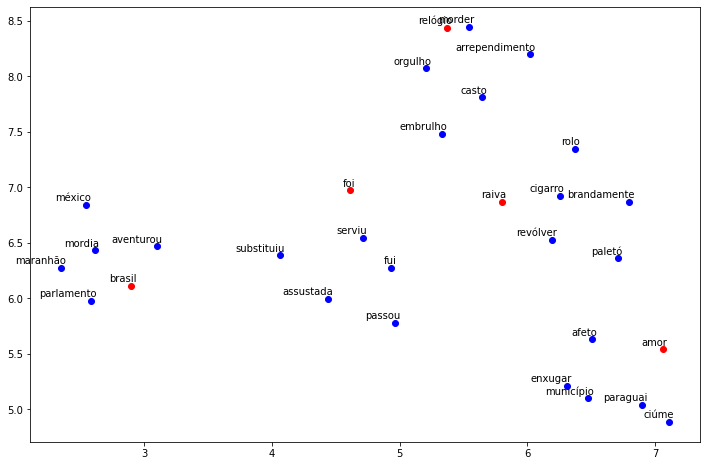

In [136]:
plot_embedding_2d(umap_result, all_words, palavras)